In [1]:
import zipline
from sklearn.linear_model import LinearRegression
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors.basic import AverageDollarVolume
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas_datareader.data as web
from datetime import datetime
start = datetime(2015, 1, 1)
end = datetime(2019, 1, 4)

## Reproduction of Beta Hedging tutorial with xarray and up to date date
* [Quantopian Beta Hedging](https://www.quantopian.com/lectures/beta-hedging)
* tickers from [Kaggle](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)



### What is beta hedging? 
* Beta is the risk you take on by holding an asset
* If some asset has high exposure to another asset you want to minimize the exposure or minimize the risk
* If you cannot minimize the exposure you want to somehow minimize the risk
* This seems like a question of participation vs non-participation and if you participate what kind of insurance do you have

### What is market neutrality? 
* portfolio=α+ β*SPY
* If the returns of our portfolio are alpha plus our exposure to the market, if we short our exposure to the marke, our returns are purely alpha
* α+(β * SPY) − (β * SPY) = α 
* strategies that have a consistent beta equal to 0 are considered market neutral
* Since Beta values are not stable over time, estimating the amount to short the SPY is difficult in practice

In [2]:
hist_prices = pd.read_csv('/Users/justinsimcock/Downloads/daily-historical-stock-prices-1970-2018/historical_stocks.csv')

In [3]:
def construct_ds(ticker, data_source, start, end):
    '''
    
    Takes a ticker symbol and data source and using 
    `pandas_datareader` it will retrieve price history
    for a ticker. Once ticker is retrieved, converts the 
    contents of the dataframe to an xarray Dataset
    
    
    Parameters
    ==========
    
    ticker: str
    data_source: str
    start: datetime object
    end: datetime object
    
    Returns
    =======
    xr.Dataset
    
    '''
    
    import pandas_datareader.data as web
    
    
    sec = web.DataReader(ticker, data_source, start, end)
    
    ds = xr.Dataset({'open':([ 'date'], sec['open']),
                 'high':(['date'], sec['high']),
                 'low':(['date'], sec['low']),
                 'close':([ 'date'], sec['close']),
                 'volume':([ 'date'], sec['volume'])},
                coords={'date':(['date'], sec.index),
                        'ticker': ticker})
    
    return ds
    
def compute_returns_xr(da, dim, period):
    '''
    Computes returns/percent change over period for a given dimension
    
    
    Parameters
    ==========
    da: xr.DataArray
    dim: str of dimension to shift
    period: int 
    
    Returns
    =======
    xr.DataArray of percentage change for given period along dim
    '''
    
    return (da - da.shift(**{dim: period}))/ da.shift(**{dim: period})    

In [4]:
# all_ds = []
# didnot_work = []

# for ticker in hist_prices['ticker'][::5]:
#     try:
#         ds = construct_ds(ticker,'iex', start,end)
#         all_ds.append(ds)
        
#     except:
#         didnot_work.append(ticker)
        
#iex_data = xr.concat(all_ds, dim='ticker')    
#iex_data['daily_returns'] = compute_returns_xr(iex_data['close'], 'date', 1)
# spx['daily_returns'] = compute_returns_xr(spx['close'], 'date', 1)

In [5]:
spx = xr.open_zarr('spy_data/')
iex = xr.open_zarr('iex_data/')


In [6]:
benchmark = spx['daily_returns']
benchmark.load()

<xarray.DataArray 'daily_returns' (date: 1009)>
array([      nan, -0.01806 , -0.009419, ...,  0.00104 , -0.023863,  0.033496])
Coordinates:
  * date     (date) datetime64[ns] 2015-01-02 2015-01-05 2015-01-06 ...
    ticker   object 'SPY'

In [7]:
exxon = iex['daily_returns'].sel(ticker='XOM')
exxon.load()

<xarray.DataArray 'daily_returns' (date: 1009)>
array([      nan, -0.027362, -0.005315, ...,  0.021997, -0.015354,  0.03687 ])
Coordinates:
  * date     (date) object '2015-01-02' '2015-01-05' '2015-01-06' ...
    ticker   <U3 'XOM'

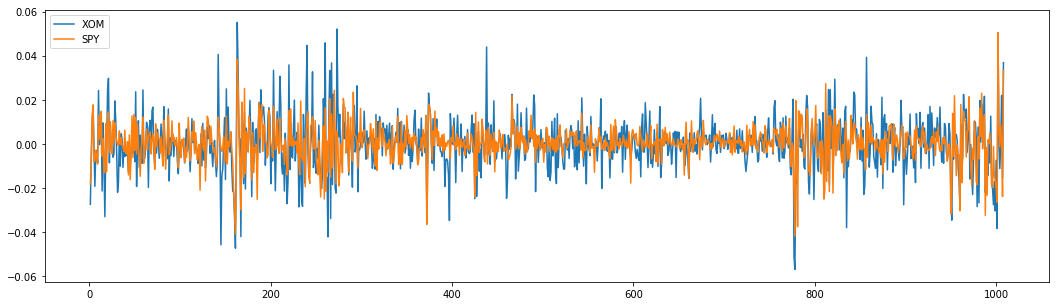

In [8]:
fig = plt.figure(figsize=(18,5))
ax = plt.subplot(111)

ax.plot(exxon, label='XOM')
ax.plot(benchmark, label='SPY')
plt.legend(loc='upper left');
plt.show()

In [9]:
def compute_linreg_params(X,y):
    '''
    
    Given a set of X's and y's of equal length 
    computes the line of best fit for the set of data
    returning the beta coefficients and y-intercept for the system
    
    Parameters
    ==========
    X: np.array of observations
    y: np.array of target
    
    Returns
    =======
    two 1-D np.arrays for the beta coeffs and y-intercept
    
    '''
    
    import numpy as np
    
    
    try:
        assert len(X) == len(y)
    except AssertionError:
        print('X and y must have the same length')
    
    #reshape so the scikits can use our data
    if not X.shape == (len(X), 1):
        X = X.reshape(len(X), 1)
    if not y.shape == (len(y), 1):
        y = y.reshape(len(y), 1)
        
        
    #remove the first observation since it is NaN
    X = X[1:]
    y = y[1:]  

    reg = LinearRegression().fit(X, y)
    return reg.coef_, reg.intercept_




In [71]:
beta_1, alpha_1 = compute_linreg_params(benchmark.values, exxon.values)

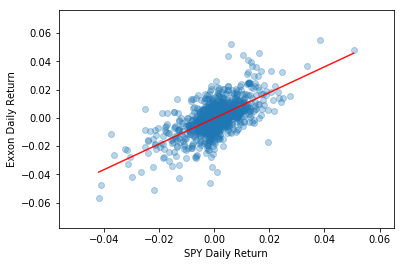

In [12]:
X2 = np.linspace(benchmark.values[1:].min(),benchmark.values[1:].max(), 100)
Y_hat = (X2 * beta + alpha).reshape(100,1)

plt.scatter(benchmark, exxon, alpha=0.3) # Plot the raw data
plt.xlabel("SPY Daily Return")
plt.ylabel("Exxon Daily Return")

 # Add the regression line, colored in red
plt.plot(X2, Y_hat, 'r', alpha=0.9);

### Hedge Implementation: Shorting our market exposure

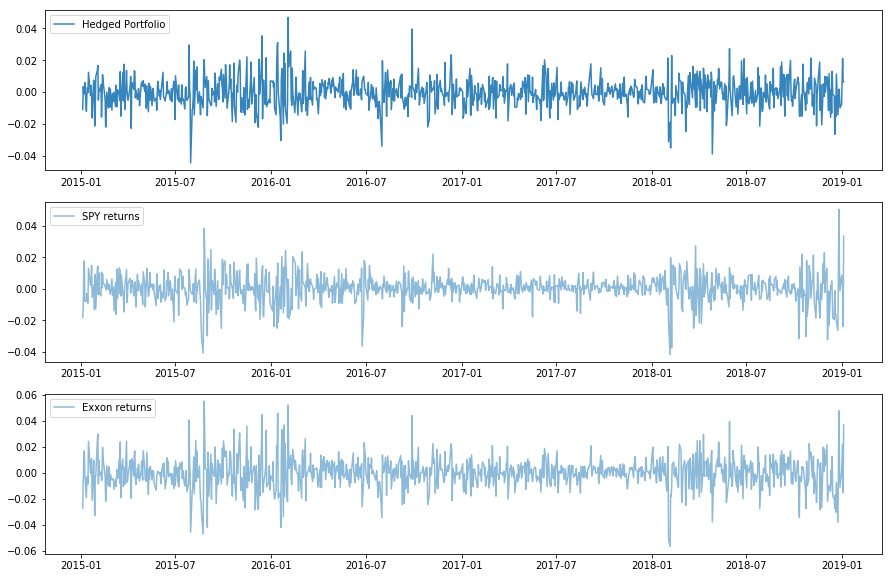

In [59]:
fig, ax = plt.subplots(3, figsize=(15,10))

portfolio = -1*beta*benchmark.values[1:] + exxon.values[1:]
#portfolio = "Exxon + Hedge"

# Plot the returns of the portfolio as well as the asset by itself
ax[0].plot(benchmark.date.values[1:], portfolio[0],alpha=0.9)
ax[0].legend(['Hedged Portfolio'], loc=2)
ax[1].plot(benchmark.date.values[1:], benchmark.values[1:],alpha=0.5);
ax[1].legend(['SPY returns'],loc=2)
ax[2].plot(benchmark.date.values[1:], exxon.values[1:], alpha=0.5);
ax[2].legend(['Exxon returns'], loc=2)


In [60]:
print('portfolio mean:', portfolio[0][1:].mean())
print('original mean:', exxon.values[1:].mean())

portfolio mean: -0.000317032143862121
original mean: -3.5610249299578146e-05


In [61]:
print('portfolio STD:', portfolio[0][1:].std())
print('original STD:', exxon.values[1:].std())

portfolio STD: 0.009254669963282081
original STD: 0.01216083784363367


In [72]:
beta_2, alpha_2 = compute_linreg_params(benchmark.values[1:],portfolio[0])

In [73]:
print('alpha:', alpha_2)
print('beta:', beta_2)

alpha: [-0.00031615]
beta: [[-0.00258647]]


In [78]:
print('original alpha:',alpha_1[0])
print('hedged alpha:', alpha_2[0])


original alpha: -0.00032756847105315897
hedged alpha: -0.00031615462838050255


In [81]:
print('original unhedged risk:', beta_1[0][0])
print('hedged risk:', beta_2[0][0])

original unhedged risk: 0.9094728214898455
hedged risk: -0.0025864662838182007


### Out of sample testing

In [94]:
exxon_2015 = exxon.sel(date=slice('2015-01-02', '2015-12-31')).values[1:]

In [93]:
spy_2015 = benchmark.sel(date=slice('2015-01-02', '2015-12-31')).values[1:]

In [95]:
beta_2015, alpha_2015 = compute_linreg_params(spy_2015, exxon_2015)

In [96]:
exxon_2016 = exxon.sel(date=slice('2016-01-01', '2016-12-31')).values[1:]
spy_2016 = benchmark.sel(date=slice('2016-01-01', '2016-12-31')).values[1:]

In [114]:
dates = benchmark.sel(date=slice('2016-01-01', '2016-12-31')).date.values[1:]

In [97]:
beta_2016, alpha_2016 = compute_linreg_params(spy_2016, exxon_2016)

In [103]:
portfolio = (-1*beta_2015*spy_2016 + exxon_2016)[0]
portfolio_beta_estimated, portfolio_alpha_estimated = compute_linreg_params(spy_2016, portfolio)

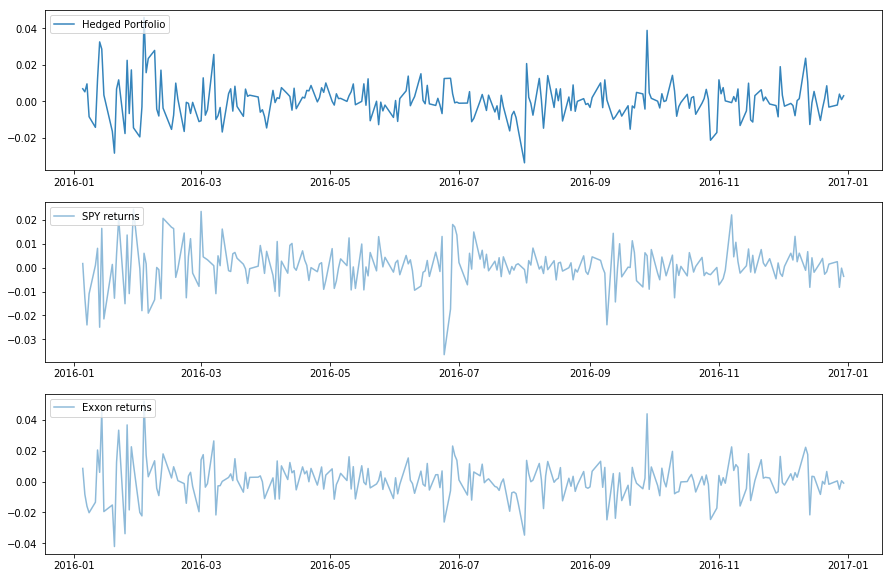

In [116]:
fig, ax = plt.subplots(3, figsize=(15,10))

portfolio = (-1*beta_2015*spy_2016 + exxon_2016)[0]
#portfolio = "Exxon + Hedge"

# Plot the returns of the portfolio as well as the asset by itself
ax[0].plot(dates, portfolio,alpha=0.9);
ax[0].legend(['Hedged Portfolio'], loc=2);
ax[1].plot(dates, spy_2016,alpha=0.5);
ax[1].legend(['SPY returns'],loc=2);
ax[2].plot(dates, exxon_2016, alpha=0.5);
ax[2].legend(['Exxon returns'], loc=2);


In [120]:
print('historical alpha:',alpha_2015[0])
print('Out of sample alpha estimate:', alpha_2016[0])
print('Hedged portfolio alpha estimate:', portfolio_alpha_estimated[0])


historical alpha: -0.000534600637403784
Out of sample alpha estimate: 0.00032997444070886287
Hedged portfolio alpha estimate: 0.0003299744407088632


In [125]:
print('historical beta', beta_2015[0][0])
print('estimated beta', beta_2016[0][0])
print('Estimated hedged portfolio beta:', portfolio_beta_estimated[0][0])

historical beta 1.0593893022135206
estimated beta 0.856557414189863
Estimated hedged portfolio beta: -0.20283188802365795


#### Conclusion and Discussion
* Our beta is not stable over time and 
* We reduced our beta exposure with the historial beta estimate, albeit only slightly

#### The alpha/beta tradeoff
* Reducing exposure to the market means we experience neither the highs nor the lows of the market
* The goal is to miss the downside returns
* The use of leverage will allow you to makeup for the upside volatility of the market exposure
